In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score


In [3]:
df = pd.read_csv("data/modelado/ds_modelado_nuevo.csv")
df_invierno = df[df["estacion_del_anio"] == 3].copy()
df_invierno = df_invierno[df_invierno["duracion_recorrido"] > 1].copy()
df_invierno = df_invierno[df_invierno["usuario_registrado"] == 1].copy()

train_df, val_df = train_test_split(
    df_invierno,
    test_size=0.2,
    random_state=42,
    stratify=df_invierno["año_intervalo"]
)

In [4]:
target = "N_arribos_intervalo"


cols_a_excluir = [
    "N_arribos_intervalo",
    "N_salidas_intervalo",         
    "id_recorrido",
    "id_estacion_destino",
    "barrio_destino",
    "zona_destino_cluster",
    "cantidad_estaciones_cercanas_destino",
    "año_destino", "mes_destino", "dia_destino",
    "hora_destino", "minuto_destino", "segundo_destino",
    "duracion_recorrido",
    "timestamp_intervalo",                  
    "salidas_acumuladas_origen",         
    "salidas_intervalo_acumuladas",       
    "recurrencia_usuario",        
"timestamp_intervalo",          
]
features = [col for col in df_invierno.columns if col not in cols_a_excluir]

X_train = train_df[features]
y_train = train_df[target]

X_val = val_df[features]
y_val = val_df[target]

In [5]:
model = RandomForestRegressor(
    random_state=42,
    n_jobs=-1,        
    max_depth=50    
)
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=50, n_jobs=-1, random_state=42)

In [6]:
y_train_pred = model.predict(X_train)
mae_train = mean_absolute_error(y_train, y_train_pred)
rmse_train = root_mean_squared_error(y_train, y_train_pred)

y_val_pred = model.predict(X_val)
mae_val = mean_absolute_error(y_val, y_val_pred)
rmse_val = root_mean_squared_error(y_val, y_val_pred)

print("Train:")
print(f"  MAE:  {mae_train:.2f}")
print(f"  RMSE: {rmse_train:.2f}")
print("Validation:")
print(f"  MAE:  {mae_val:.2f}")
print(f"  RMSE: {rmse_val:.2f}")

Train:
  MAE:  0.47
  RMSE: 0.70
Validation:
  MAE:  1.28
  RMSE: 1.87


In [7]:
r2_train = r2_score(y_train, y_train_pred)
r2_val = r2_score(y_val, y_val_pred)

print(f"R² Train: {r2_train:.3f}")
print(f"R² Val:   {r2_val:.3f}")

R² Train: 0.905
R² Val:   0.327


In [8]:
df_invierno["N_arribos_intervalo"].describe()

count    2.460211e+06
mean     2.729508e+00
std      2.262676e+00
min      1.000000e+00
25%      1.000000e+00
50%      2.000000e+00
75%      3.000000e+00
max      3.700000e+01
Name: N_arribos_intervalo, dtype: float64

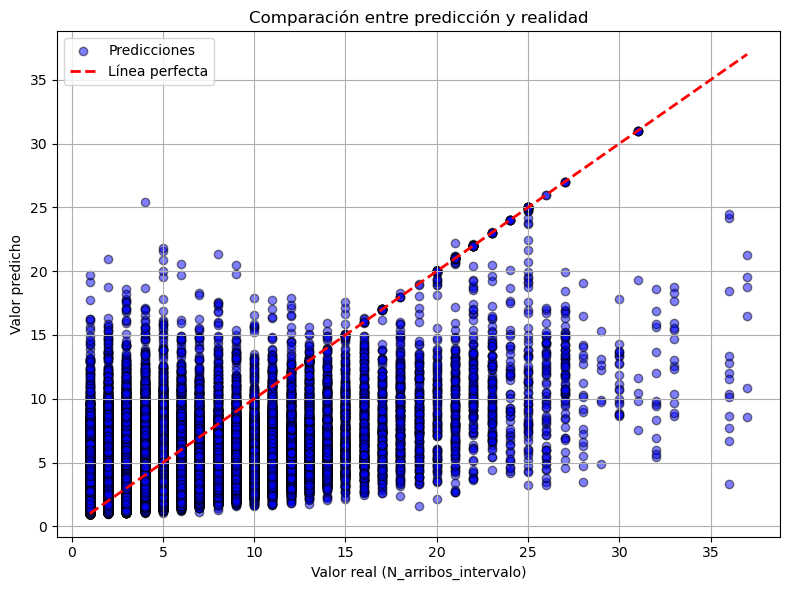

In [9]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(8, 6))

# Puntos reales vs predichos
plt.scatter(y_val, y_val_pred, color="blue", alpha=0.5, edgecolors="k", label="Predicciones")

# Línea perfecta
min_val = min(y_val.min(), y_val_pred.min())
max_val = max(y_val.max(), y_val_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label="Línea perfecta")

plt.xlabel("Valor real (N_arribos_intervalo)")
plt.ylabel("Valor predicho")
plt.title("Comparación entre predicción y realidad")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

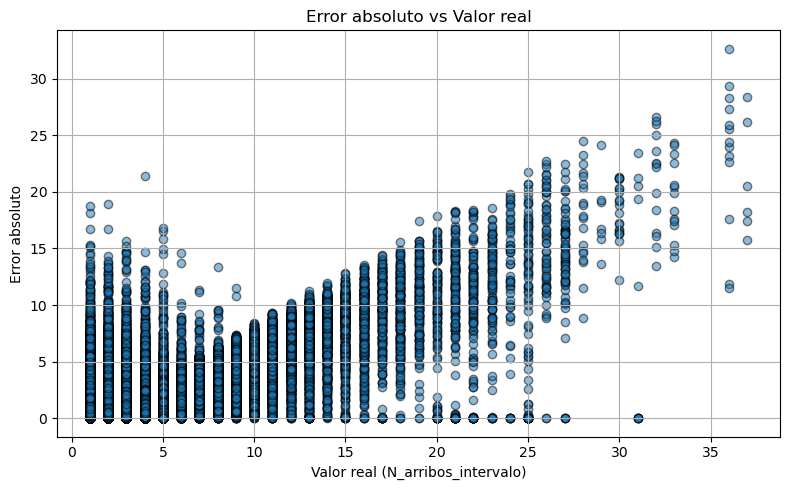

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# Calcular error absoluto
errores_abs = np.abs(y_val - y_val_pred)

plt.figure(figsize=(8, 5))
plt.scatter(y_val, errores_abs, alpha=0.5, edgecolors="k")
plt.xlabel("Valor real (N_arribos_intervalo)")
plt.ylabel("Error absoluto")
plt.title("Error absoluto vs Valor real")
plt.grid(True)
plt.tight_layout()
plt.show()

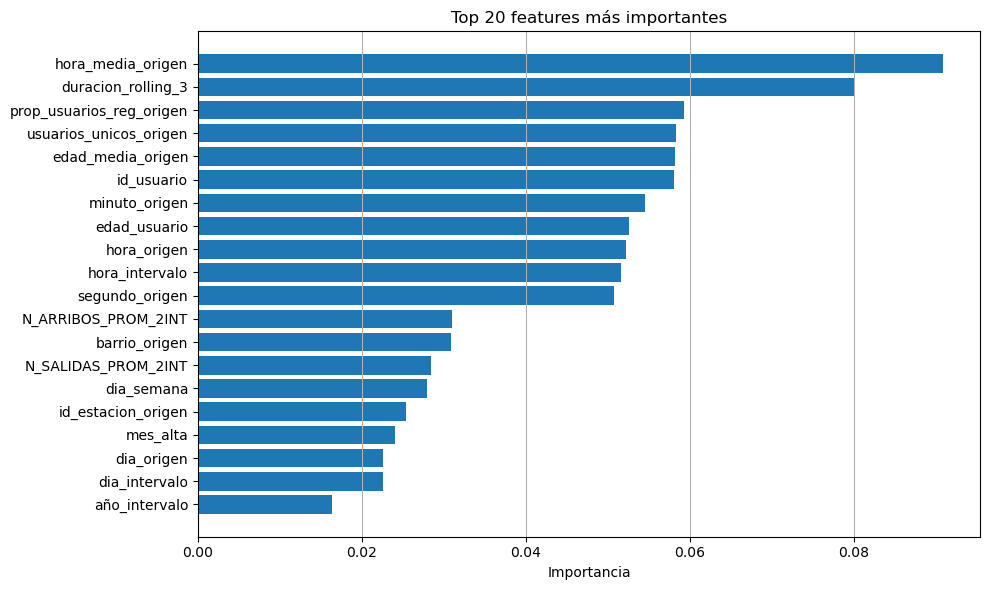

In [11]:
import pandas as pd

# Crear DataFrame con las importancias
importancias = model.feature_importances_
importancias_df = pd.DataFrame({
    "feature": X_train.columns,
    "importancia": importancias
}).sort_values(by="importancia", ascending=False)

# Graficar las top 20
plt.figure(figsize=(10, 6))
plt.barh(importancias_df["feature"][:20][::-1], importancias_df["importancia"][:20][::-1])
plt.xlabel("Importancia")
plt.title("Top 20 features más importantes")
plt.grid(True, axis='x')
plt.tight_layout()
plt.show()

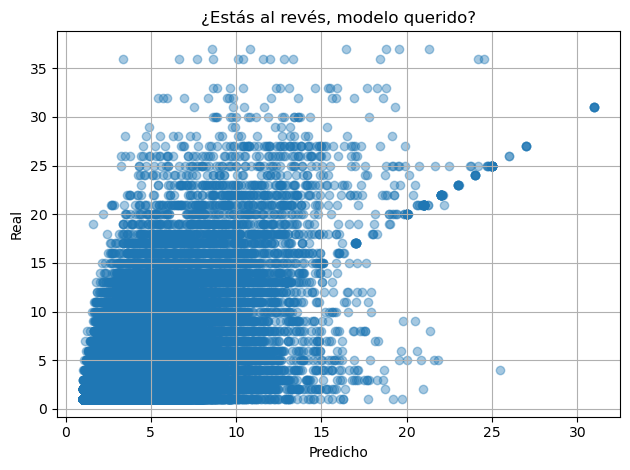

In [12]:
import matplotlib.pyplot as plt

plt.scatter(y_val_pred, y_val, alpha=0.4)
plt.xlabel("Predicho")
plt.ylabel("Real")
plt.title("¿Estás al revés, modelo querido?")
plt.grid(True)
plt.tight_layout()
plt.show()

In [13]:
from sklearn.ensemble import HistGradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score

for quantile in [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    model_q90 = HistGradientBoostingRegressor(loss='quantile', quantile=quantile, random_state=42)
    model_q90.fit(X_train, y_train)

    # Predicción
    y_pred_q90 = model_q90.predict(X_val)

    # Métricas
    mae_q90 = mean_absolute_error(y_val, y_pred_q90)
    rmse_q90 = root_mean_squared_error(y_val, y_pred_q90)
    r2_q90 = r2_score(y_val, y_pred_q90)

    print(f"MAE (q={quantile}): {mae_q90:.2f}")
    print(f"RMSE (q={quantile}): {rmse_q90:.2f}")
    print(f"R²   (q={quantile}): {r2_q90:.3f}")

MAE (q=0.1): 1.73
RMSE (q=0.1): 2.86
R²   (q=0.1): -0.582
MAE (q=0.2): 1.73
RMSE (q=0.2): 2.86
R²   (q=0.2): -0.582
MAE (q=0.3): 1.73
RMSE (q=0.3): 2.86
R²   (q=0.3): -0.579
MAE (q=0.4): 1.32
RMSE (q=0.4): 2.25
R²   (q=0.4): 0.016
MAE (q=0.5): 1.27
RMSE (q=0.5): 2.07
R²   (q=0.5): 0.171
MAE (q=0.6): 1.31
RMSE (q=0.6): 1.98
R²   (q=0.6): 0.239
MAE (q=0.7): 1.45
RMSE (q=0.7): 2.01
R²   (q=0.7): 0.214
MAE (q=0.8): 1.78
RMSE (q=0.8): 2.30
R²   (q=0.8): -0.025
MAE (q=0.9): 2.54
RMSE (q=0.9): 3.12
R²   (q=0.9): -0.886


In [14]:
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

In [15]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

model_xgb = XGBRegressor(
    n_estimators=1000,
    max_depth=17,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_xgb.fit(X_train, y_train)
y_pred = model_xgb.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📈 XGBoost Metrics")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")


📈 XGBoost Metrics
MAE: 1.26
RMSE: 1.85
R²: 0.341


In [16]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

model_xgb_poisson = XGBRegressor(
    n_estimators=800,
    max_depth=15,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective="count:poisson",
    random_state=42,
    n_jobs=-1
)

model_xgb_poisson.fit(X_train, y_train)
y_pred = model_xgb_poisson.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📈 XGBoost con Poisson")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

📈 XGBoost con Poisson
MAE: 1.22
RMSE: 1.84
R²: 0.348


/var/folders/6y/f0qlfq094gx2tt5rz2y_xphm0000gn/T/ipykernel_45154/3216030814.py:20: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  plt.tight_layout()
/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 127919 (\N{DIRECT HIT}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


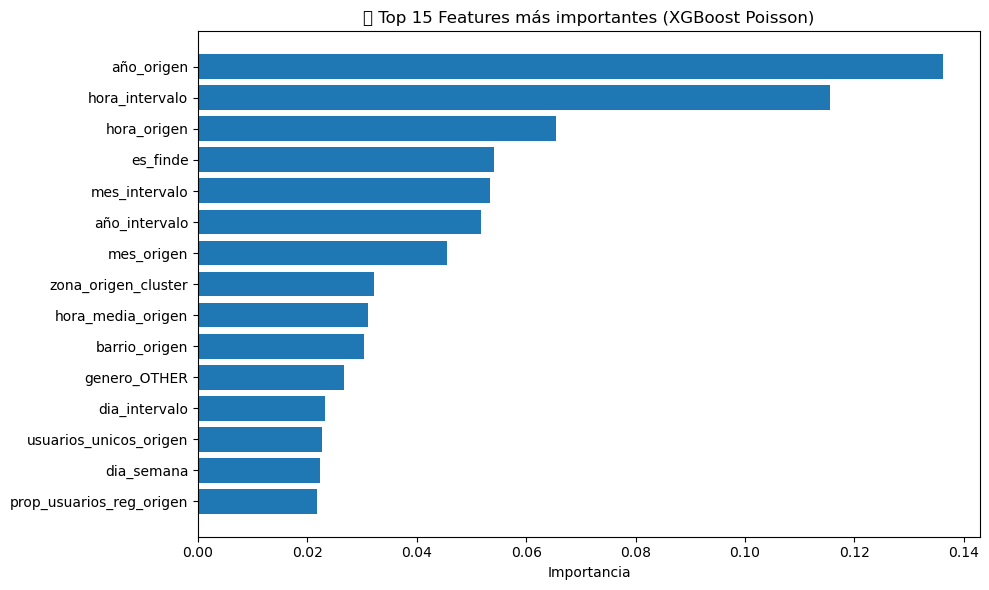

In [17]:
import matplotlib.pyplot as plt
import pandas as pd

# Obtener importancias de las features
importances = model_xgb_poisson.feature_importances_
feature_names = X_train.columns

# Crear DataFrame ordenado
feat_imp_df = pd.DataFrame({
    "feature": feature_names,
    "importance": importances
}).sort_values(by="importance", ascending=False).head(15)

# Gráfico
plt.figure(figsize=(10, 6))
plt.barh(feat_imp_df["feature"], feat_imp_df["importance"])
plt.gca().invert_yaxis()  # Para que la más importante quede arriba
plt.xlabel("Importancia")
plt.title("🎯 Top 15 Features más importantes (XGBoost Poisson)")
plt.tight_layout()
plt.show()

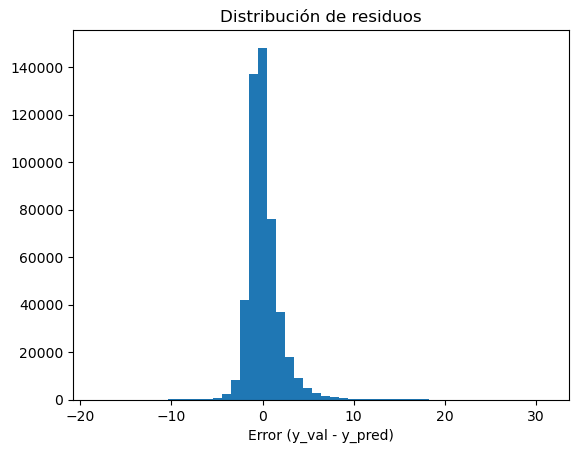

In [18]:
import matplotlib.pyplot as plt
plt.hist(y_val - y_pred, bins=50)
plt.title("Distribución de residuos")
plt.xlabel("Error (y_val - y_pred)")
plt.show()

In [19]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error, r2_score
import numpy as np

import lightgbm as lgb

model_lgb = lgb.LGBMRegressor(
    objective="poisson",
    learning_rate=0.05,
    n_estimators=1000,
    max_depth=17,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    n_jobs=-1
)

model_lgb.fit(X_train, y_train)
y_pred = model_lgb.predict(X_val)

mae = mean_absolute_error(y_val, y_pred)
rmse = root_mean_squared_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print("📈 LightGBM Metrics")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.3f}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.010788 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2343
[LightGBM] [Info] Number of data points in the train set: 1968168, number of used features: 33
[LightGBM] [Info] Start training from score 1.003654
📈 LightGBM Metrics
MAE: 1.29
RMSE: 1.90
R²: 0.299
